# Read Dectris Eiger 1M hdf5 files and export the image

## open hdf5

In [1]:
%matplotlib inline
import h5py
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
rc('font',**{'family':'sns-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
def dispImage(img,min=0,max=1024, log=True):
    ## image plotter ##
      plt.ion()
      if img is None: return
      figure = plt.figure(figsize=(16,4))
      #plt.xlim(600,760)
      #plt.ylim(405,287)
      if log:
          img = np.log(img)
      pltimg = img.astype(np.float32)
      im = plt.imshow(pltimg,cmap=cm.nipy_spectral)
      plt.colorbar()
      im.set_clim(min,max)
      plt.draw()
      #input("press enter to continue")
      
      return figure

In [3]:
class ImageReadException(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [4]:
def createLUT(hdf5File):
    LUT = {}
    entry = hdf5File['entry']

    
    for datalink in list(entry['data']):
        if not(datalink[0:4] == 'data'): 
            continue
        
        ### open the link ###
        try:
            data = entry['data'][datalink]
        except KeyError as exception: ### cannot open link, probably file does not exist
            continue

        ### read the image_nr_low and image_nr_high attributes ###
        image_nr_low  = data.attrs['image_nr_low']
        image_nr_high = data.attrs['image_nr_high']

        for imgNr in range(image_nr_low-1, image_nr_high):
            LUT[imgNr] = (datalink, imgNr-image_nr_low)
    
    return LUT

In [5]:
def readImage(imgNr, LUT, hdf5File):
    datalink = ''
    try:
        (datalink,imageNrOffset) = LUT[imgNr]
    except KeyError as e:
        raise ImageReadException('imgNr ({0}) out of range'.format(imgNr))
    
    
    data = hdf5File['entry']['data'][datalink]
    ### use slicing access to get images with image number imageNrOffset ###
    image = data[imageNrOffset, : , : ] ## z / y / x
    return image ## is a numpy array

In [6]:
def exportImageArray(masterFilename):
    hdf5File = h5py.File(masterFilename, 'r')
    LUT = createLUT(hdf5File)
    imgNr = 0
    image = readImage(imgNr, LUT, hdf5File)+1.0
    return image

In [7]:
def Convertto1D(image):
    image = image.astype(np.float32)
    rows, columns = (len(image) * len(image[0])), 3
    dataarray = [0] * rows
    for i in range(rows):
        dataarray[i] = [0] * columns
    interval = 0
    for y in range (len(image)):
        for x in range (len(image[0])):
            dataarray[interval][0] = float(x)
            dataarray[interval][1] = float(y)
            dataarray[interval][2] = image[y][x]
            interval = interval + 1
    dataarray = np.array(dataarray)
    return dataarray

In [8]:
def Convertto1D_slice(x0,y0,image):
    image = image.astype(np.float32)
    rows, columns = (len(image) * len(image[0])), 3
    dataarray = [0] * rows
    for i in range(rows):
        dataarray[i] = [0] * columns
    interval = 0
    for y in range (len(image)):
        for x in range (len(image[0])):
            dataarray[interval][0] = float(x+x0)
            dataarray[interval][1] = float(y+y0)
            dataarray[interval][2] = image[y][x]
            interval = interval + 1
    dataarray = np.array(dataarray)
    return dataarray

## Display and Export image

In [52]:
def export_xy_Image(image, imageFilename, log = True):

    if image is None: return
    fig = plt.figure(figsize=(12,10),dpi=100)

    if log:
        image = np.log(image)
    pltimg = image.astype(np.float32)
    
    axes = fig.add_axes([0.,0.1,1,0.85]) # left, bottom, width, height (range 0 to 1)

    im = plt.imshow(pltimg,cmap=cm.nipy_spectral)
    
    axes.set_xlabel(r'[$x$]', fontsize=25)
    axes.set_ylabel(r'[$y$]', fontsize=25)
    #axes.set_xlim(600,900)
    #axes.set_ylim(700,250)
    axes.text(765,299,'STO', fontsize=10, color = 'w')
    axes.text(765,329,'SRO', fontsize=10, color = 'w')
    axes.text(765,398,'BTO strained', fontsize=10, color = 'w')
    #axes.legend(loc = 2, fontsize=40, numpoints=1,markerscale=3)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    #axes.grid(True)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes("right", size="5%", pad=0.3)
    cbar = plt.colorbar(cax=cax)
    cbar.set_label('Log',fontsize=15)
    cbar.ax.tick_params(labelsize=20)

    im.set_clim(0,12)

    plt.savefig(imageFilename)
    plt.draw()

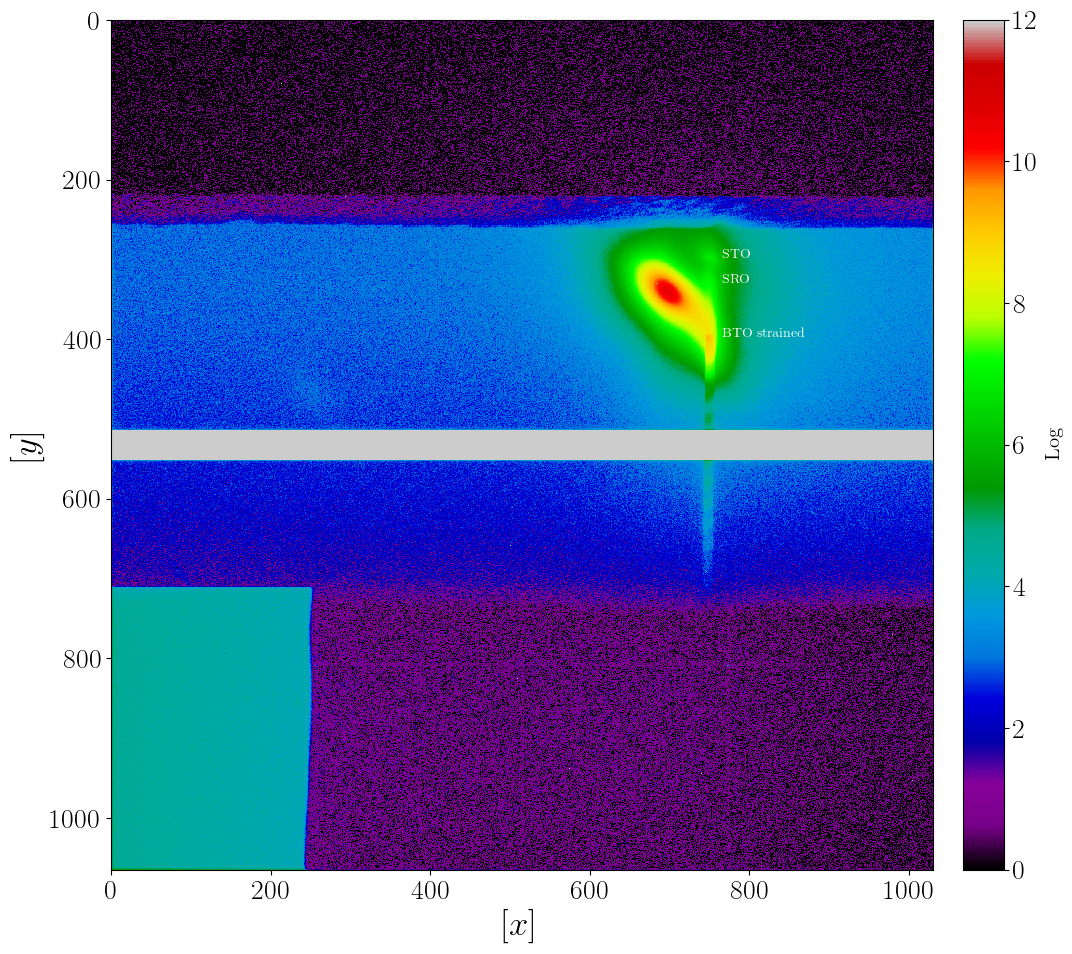

In [53]:
masterFilename1 = '/Users/Rui/Google Drive/Research/STONY BROOK/Matt Dawber/NSLS2/ISR/Summer2017/Data/calibration/calibrate_020_004_master.h5'
image1 = exportImageArray(masterFilename1)
imageFilename1 = '/Users/Rui/Google Drive/Research/STONY BROOK/Matt Dawber/NSLS2/ISR/Summer2017/Images/Test_xy.pdf'
export_xy_Image(image1, imageFilename1, log=True)

## Display and Export slice image

In [42]:
def export_xy_Image_slice(image, sliceimageFilename, log = True):
    if image is None: return
    image = image.T
    fig = plt.figure(figsize=(14,5.5),dpi=100)

    if log:
        image = np.log(image)
    pltimg = image.astype(np.float32)
    
    axes = fig.add_axes([0.1,0.11,0.85,0.85]) # left, bottom, width, height (range 0 to 1)

    im = plt.imshow(pltimg,cmap=cm.nipy_spectral,vmin=0,vmax=12)
    
    axes.set_xlabel(r'[$y$]', fontsize=25)
    axes.set_ylabel(r'[$x$]', fontsize=25)
    axes.set_ylim(775,600)
    axes.set_xlim(250,750)
    axes.text(289,770,'STO', fontsize=20, color = 'black')
    axes.text(319,770,'SRO', fontsize=20, color = 'black')
    axes.text(388,770,'BTO strained', fontsize=20, color = 'black')
    #axes.legend(loc = 2, fontsize=40, numpoints=1,markerscale=3)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    #axes.grid(True)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(cax=cax)
    cbar.set_label('Log',fontsize=15)
    cbar.ax.tick_params(labelsize=20)

    #im.set_clim(3,12)

    plt.savefig(sliceimageFilename)
    plt.draw()

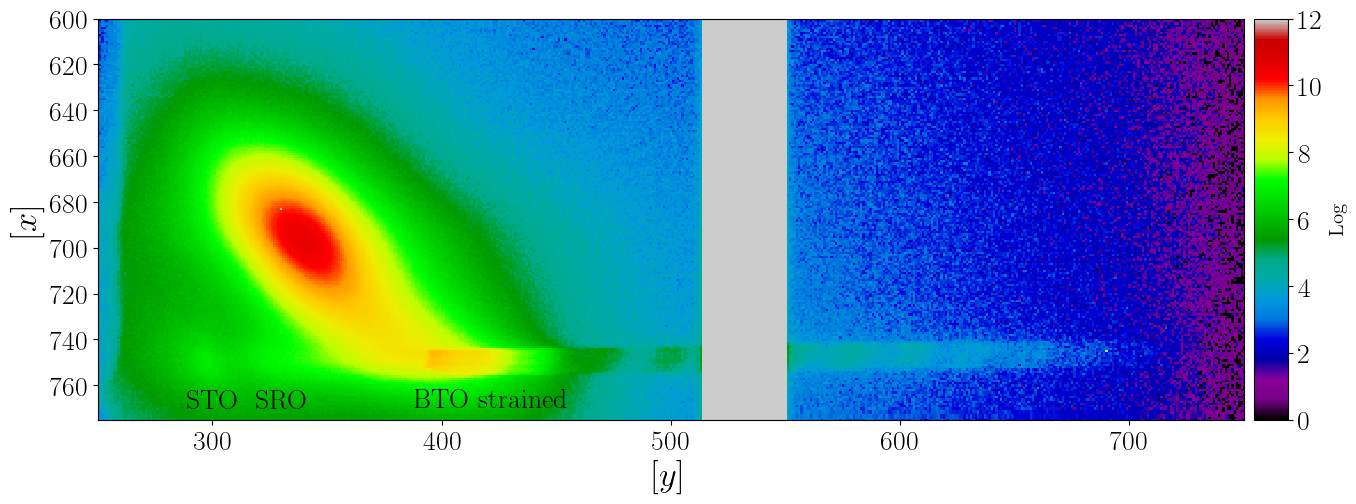

In [43]:
masterFilename1 = '/Users/Rui/Google Drive/Research/STONY BROOK/Matt Dawber/NSLS2/ISR/Summer2017/Data/calibration/calibrate_020_004_master.h5'
#masterFilename1 = '/Users/Rui/Google Drive/Research/STONY BROOK/Matt Dawber/NSLS2/ISR/Summer2017/Data/ISR0615172_map500_4uc/map500_4uc_004_000_master.h5'
image1 = exportImageArray(masterFilename1)
sliceimageFilename1 = '/Users/Rui/Google Drive/Research/STONY BROOK/Matt Dawber/NSLS2/ISR/Summer2017/Images/Test_xy_slice.pdf'
export_xy_Image_slice(image1, sliceimageFilename1, log=True)

## Display and export 3D image

In [37]:
import datetime
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
def export_xy_Image_slice_3D(image, imageFilename, log = True):
    t1 = datetime.datetime.now()

    if image is None: return
    image[image>4000000000] =0.0
    image = image.T
    fig = plt.figure(figsize=(14,5.5),dpi=100)

    if log:
        image = np.log(image)
    pltimg = image.astype(np.float32)
    ax = fig.gca(projection='3d')
    X = np.arange(0, image.shape[1], 1)
    Y = np.arange(0, image.shape[0], 1)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, pltimg, cmap=cm.nipy_spectral, linewidth=0, antialiased=False,vmin=0,vmax=12)
    #ax.set_zlim(0, 12)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlim(250,750)
    ax.set_ylim(775,600)

# Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    #for angle in range (0, 360):
       # ax.view_init(30, angle)
    plt.draw()
    t2 = datetime.datetime.now()
    print(t2-t1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/anaconda/lib/python3.6/site-packages/mpl_toolkits/mplot3d/proj3d.py:160: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


0:00:01.081601


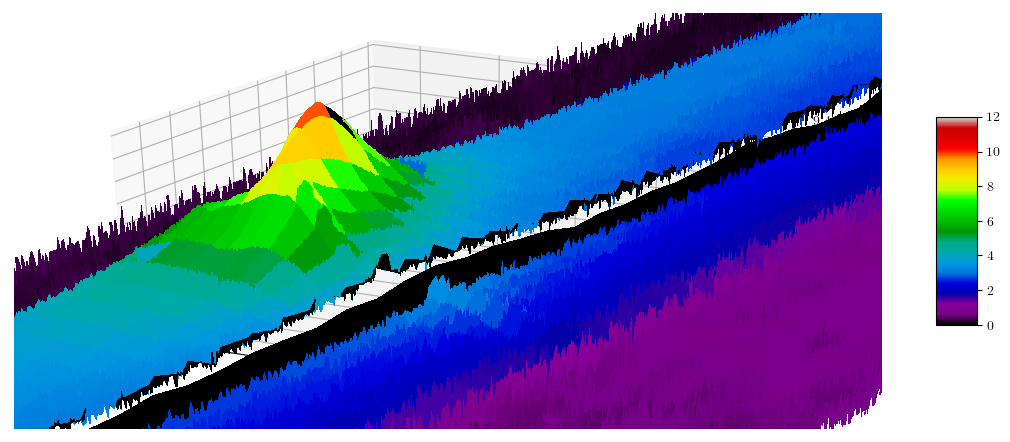

In [38]:
masterFilename1 = '/Users/Rui/Google Drive/Research/STONY BROOK/Matt Dawber/NSLS2/ISR/Summer2017/Data/calibration/calibrate_020_004_master.h5'
#masterFilename1 = '/Users/Rui/Google Drive/Research/STONY BROOK/Matt Dawber/NSLS2/ISR/Summer2017/Data/ISR0615172_map500_4uc/map500_4uc_004_000_master.h5'
image1 = exportImageArray(masterFilename1)
sliceimageFilename1 = '/Users/Rui/Google Drive/Research/STONY BROOK/Matt Dawber/NSLS2/ISR/Summer2017/Images/Test_xy_slice.pdf'
export_xy_Image_slice_3D(image1, sliceimageFilename1, log=True)